In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

In [2]:
P_THRESHOLD=0.5

### read in data

In [3]:
DATADIR = os.getenv('DATADIR')

In [4]:
print("model v2.0.0 was run on data dated {}".format(DATADIR))

model v2.0.0 was run on data dated /data/2018-03-12


In [5]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

In [6]:
labelled_level2.taxon_id.nunique()

2552

In [7]:
new_pred = pd.read_csv(
    os.path.join(DATADIR, 'new_predictions_1726_1203_.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [8]:
new_content = pd.read_csv(
    os.path.join(DATADIR, 'new_content.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [9]:
new_content.columns

Index(['base_path', 'body', 'combined_text', 'content_id',
       'content_purpose_document_supertype', 'content_purpose_subgroup',
       'content_purpose_supergroup', 'description', 'details', 'document_type',
       'document_type_gp', 'email_document_supertype', 'first_published_at',
       'government_document_supertype', 'locale',
       'navigation_document_supertype', 'primary_publishing_organisation',
       'public_updated_at', 'publishing_app',
       'search_user_need_document_supertype', 'taxon_id', 'taxons', 'title',
       'untagged_type', 'updated_at', 'user_journey_document_supertype'],
      dtype='object')

In [10]:
new_content.shape

(87177, 26)

In [11]:
new_content.content_id.nunique()

87176

In [12]:
new_content.groupby('publishing_app').size().sort_values()

publishing_app
frontend                     1
collections-publisher        2
smartanswers                14
manuals-publisher           40
policy-publisher           204
hmrc-manuals-api           220
content-tagger             223
publisher                  915
specialist-publisher      2589
whitehall                82969
dtype: int64

In [13]:
new_content.shape

(87177, 26)

In [14]:
new_arrays = np.load(os.path.join(DATADIR, 'new_arrays.npz'))

In [15]:
new_arrays.files

['x', 'meta', 'title', 'desc', 'content_id']

In [16]:
new_arrays['content_id'].shape

(87177,)

### combine data

In [17]:
if new_arrays['content_id'].shape[0] == new_pred.shape[0]:
    new_pred['content_id'] = new_arrays['content_id']
else:
    print("warning: true_train and content_id may not originate from same data")
    
    

In [18]:
new_pred['content_id'].nunique()

87176

In [19]:
newprob_by_id = pd.melt(new_pred, 
                        id_vars=['content_id'], var_name='taxon2', value_name='prob')

In [20]:
newprob_by_id.shape

(19004586, 3)

In [21]:
#convert from string to numeric
newprob_by_id['prob'] = pd.to_numeric(newprob_by_id['prob'])
newprob_by_id['taxon2'] = pd.to_numeric(newprob_by_id['taxon2'])

In [22]:
#get the label for the level2 taxon code
newprob_by_id['taxon2label'] = newprob_by_id['taxon2'].map(labels_index)

In [23]:
newprob_meta = pd.merge(
    left=newprob_by_id,
    right=new_content,
    on='content_id',
    how='left',
    indicator=True, 
    validate='m:m'
)

In [24]:
newprob_meta.columns

Index(['content_id', 'taxon2', 'prob', 'taxon2label', 'base_path', 'body',
       'combined_text', 'content_purpose_document_supertype',
       'content_purpose_subgroup', 'content_purpose_supergroup', 'description',
       'details', 'document_type', 'document_type_gp',
       'email_document_supertype', 'first_published_at',
       'government_document_supertype', 'locale',
       'navigation_document_supertype', 'primary_publishing_organisation',
       'public_updated_at', 'publishing_app',
       'search_user_need_document_supertype', 'taxon_id', 'taxons', 'title',
       'untagged_type', 'updated_at', 'user_journey_document_supertype',
       '_merge'],
      dtype='object')

#### drop content ids which are really taxons

In [25]:
#drop taxons document type. Why are these here? Shoudl be cleaned in create_new?
newprob_meta = newprob_meta[newprob_meta['document_type']!='taxon']

In [26]:
newprob_meta.shape

(18955972, 30)

In [27]:
newprob_meta.content_id.nunique()

86953

## categorical var for probaiblity

In [169]:
newprob_meta['prob_cat'] = '>0.8'
newprob_meta.loc[newprob_meta['prob']<0.01, 'prob_cat'] = '<0.01'
newprob_meta.loc[(newprob_meta['prob']>=0.01) & (newprob_meta['prob']<0.1), 'prob_cat'] = '0.01-0.1'
newprob_meta.loc[(newprob_meta['prob']>=0.1) & (newprob_meta['prob']<0.2), 'prob_cat'] = '0.1-0.2'
newprob_meta.loc[(newprob_meta['prob']>=0.2) & (newprob_meta['prob']<0.3), 'prob_cat'] = '0.2-0.3'
newprob_meta.loc[(newprob_meta['prob']>=0.3) & (newprob_meta['prob']<0.4), 'prob_cat'] = '0.3-0.4'
newprob_meta.loc[(newprob_meta['prob']>=0.4) & (newprob_meta['prob']<0.5), 'prob_cat'] = '0.4-0.5'
newprob_meta.loc[(newprob_meta['prob']>=0.5) & (newprob_meta['prob']<0.6), 'prob_cat'] = '0.5-0.6'
newprob_meta.loc[(newprob_meta['prob']>=0.6) & (newprob_meta['prob']<0.7), 'prob_cat'] = '0.6-0.7'
newprob_meta.loc[(newprob_meta['prob']>=0.7) & (newprob_meta['prob']<0.8), 'prob_cat'] = '0.7-0.8'

In [172]:
newprob_meta.groupby(['prob_cat']).content_id.nunique()

prob_cat
0.01-0.1    57393
0.1-0.2     31177
0.2-0.3     21637
0.3-0.4     16681
0.4-0.5     11816
0.5-0.6      8606
0.6-0.7      7501
0.7-0.8      7767
<0.01       86542
>0.8        51703
Name: content_id, dtype: int64

### count content items

In [28]:
newprob_meta[newprob_meta['untagged_type']=='untagged'].content_id.nunique()

69678

In [29]:
newprob_meta.groupby('untagged_type')['content_id'].nunique()

untagged_type
old_taxons    17275
untagged      69678
Name: content_id, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf4d193940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faf35ebdba8>]], dtype=object)

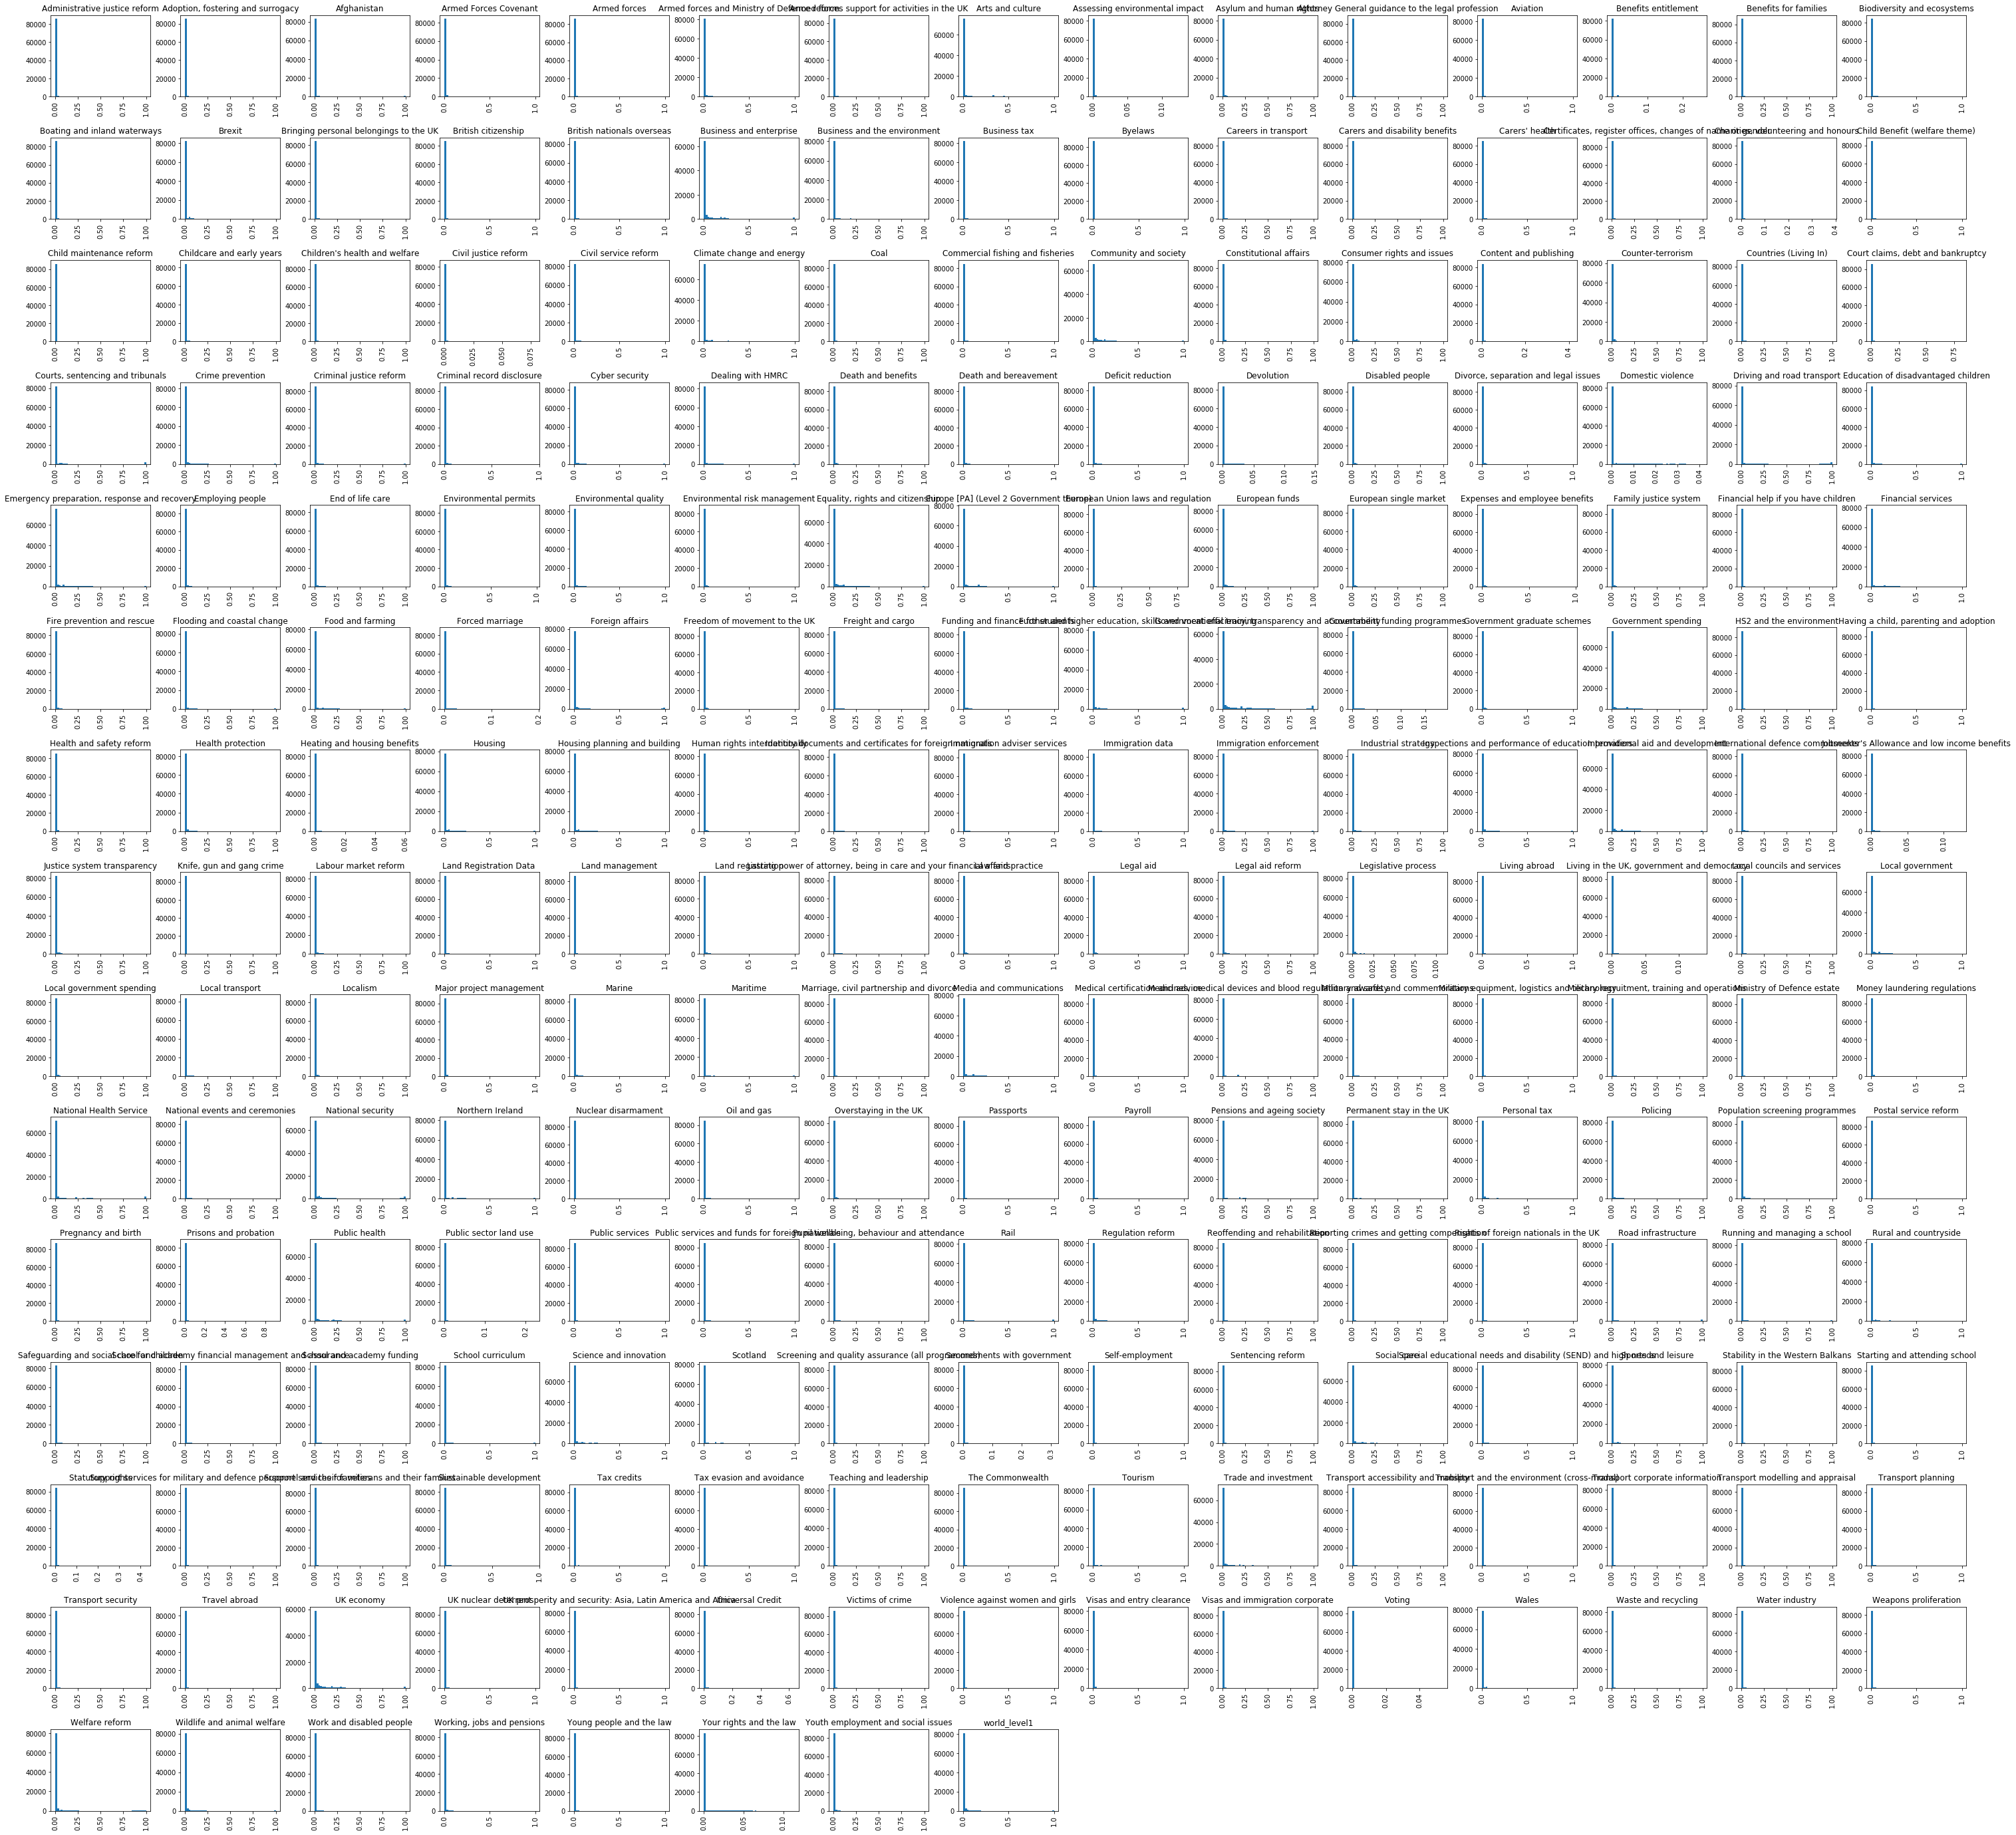

In [30]:
newprob_meta['prob'].hist(by=newprob_meta['taxon2label'], figsize=(50, 50), bins=50)

In [31]:
newprob_meta[newprob_meta['prob']<0.01].shape

(17831931, 30)

In [32]:
newprob_meta[newprob_meta['prob']<0.01].shape[0]/newprob_meta.shape[0]

0.9407025395479588

In [33]:
atleast1pct = newprob_meta[newprob_meta['prob']>=0.01]
atleast1pct.shape

(1124041, 30)

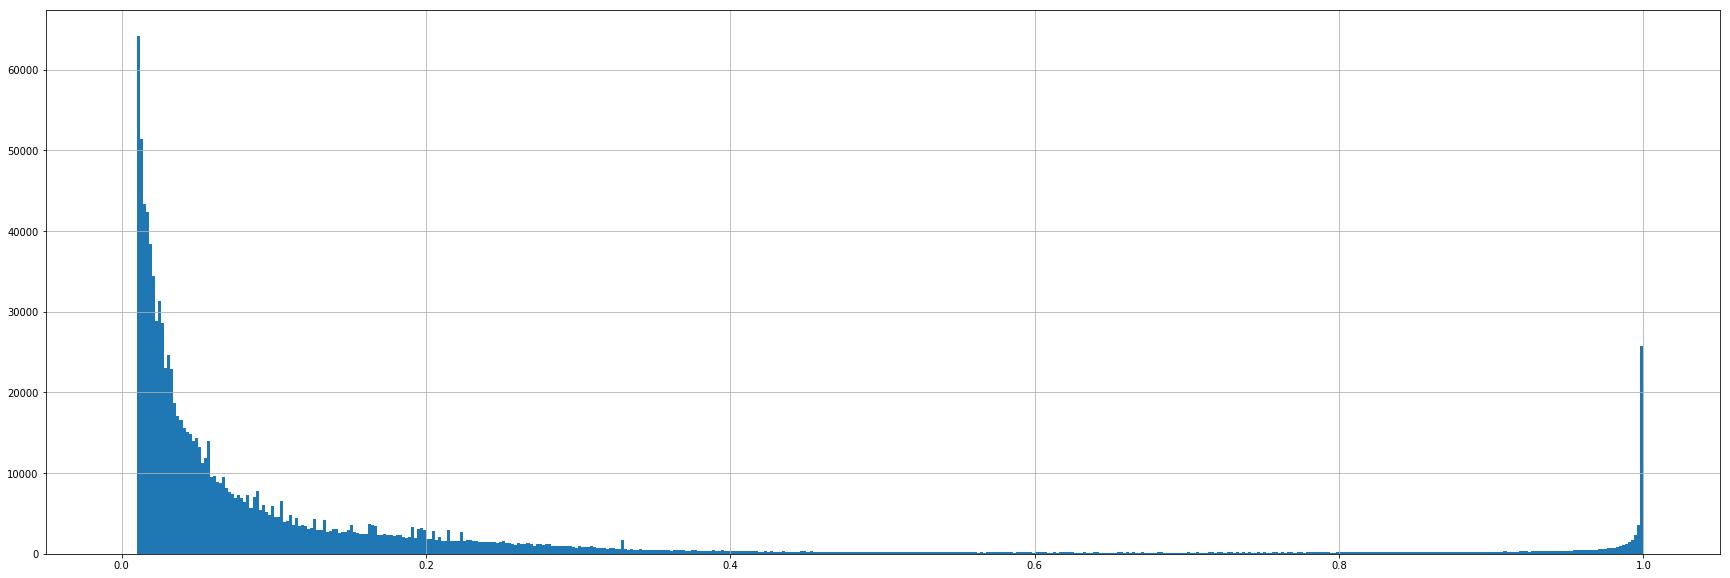

In [34]:
atleast1pct['prob'].hist(range=(0, 1), figsize=(30, 10), bins=500)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf35570320>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fade2e4d320>], dtype=object)

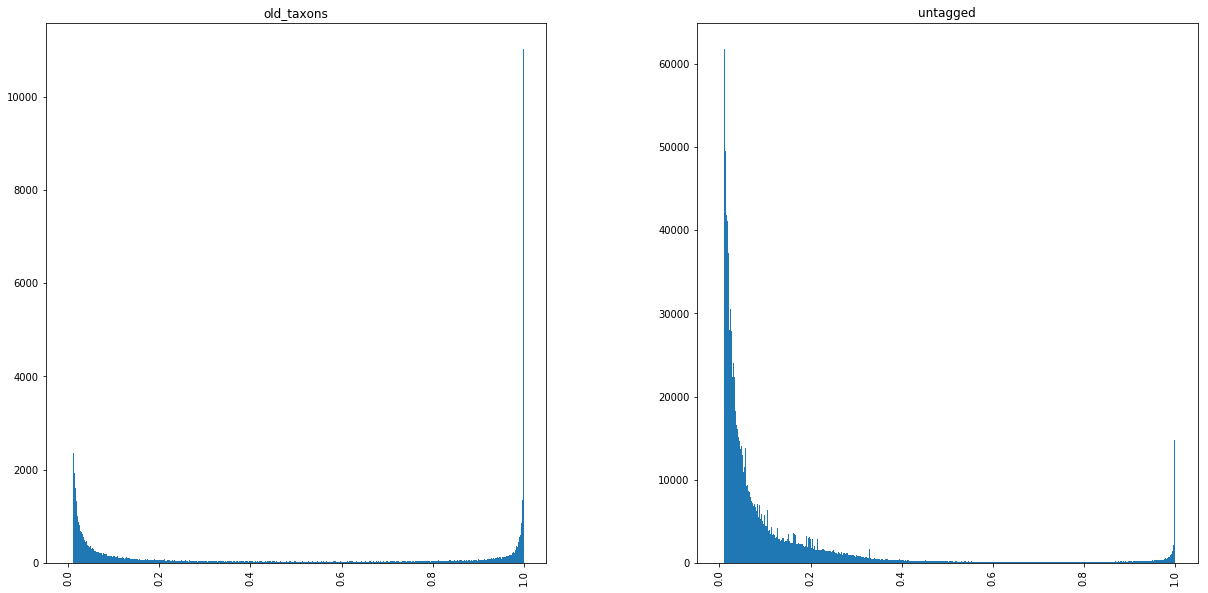

In [35]:
atleast1pct['prob'].hist(by=atleast1pct['untagged_type'], range=(0, 1), figsize=(20, 10), bins=500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf0113fe80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faef9b50f98>]], dtype=object)

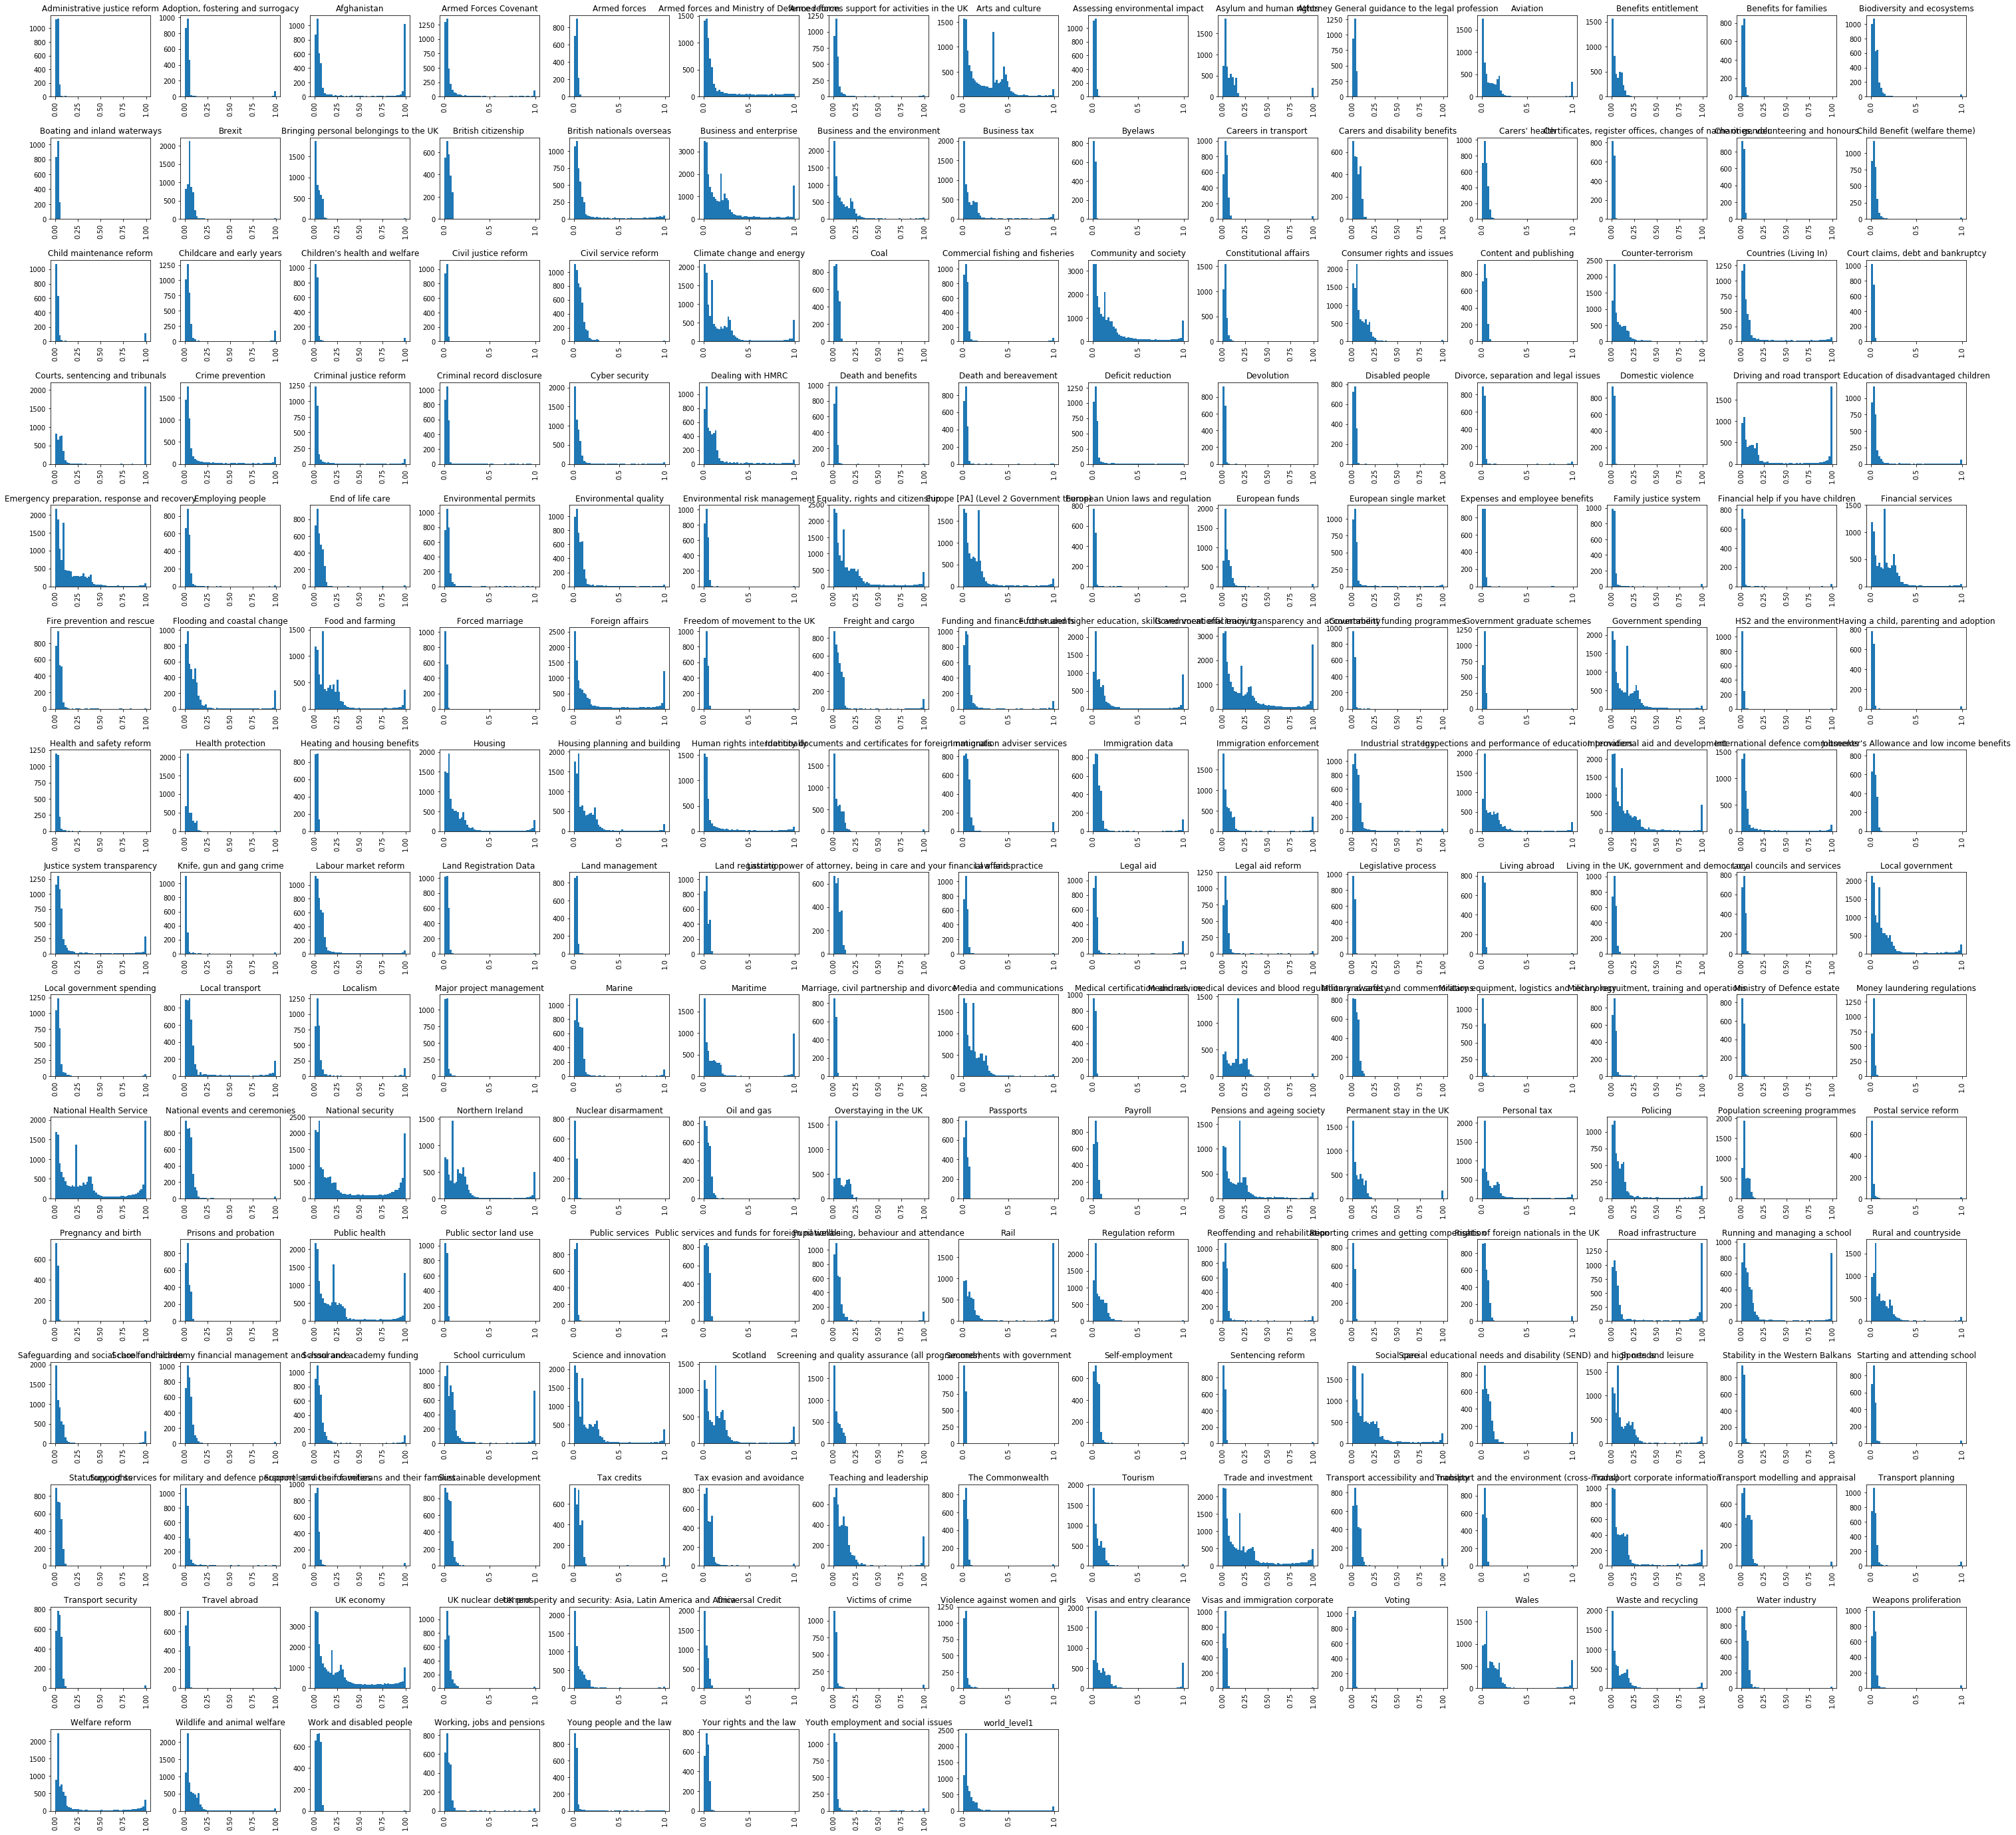

In [36]:
#TODO: work out how to standardise ylim to 0, 3000 
atleast1pct['prob'].hist(by=atleast1pct['taxon2label'], range=(0, 1), figsize=(50, 50), bins=50)

In [37]:
78696/101912

0.7721956197503729

In [38]:
predictions = newprob_meta[newprob_meta['prob'] > 0.5]

In [39]:
predictions.groupby('untagged_type')['content_id'].nunique()

untagged_type
old_taxons    16808
untagged      47766
Name: content_id, dtype: int64

In [40]:
untagged_predictions = predictions[predictions['untagged_type']=='untagged']
oldtaxons_predictions = predictions[predictions['untagged_type']!='untagged']

In [41]:
untagged_predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    47766.000000
mean         1.322468
std          0.621638
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         11.000000
dtype: float64

In [42]:
labelled_level2.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    123900.000000
mean          1.391001
std           0.778077
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          35.000000
dtype: float64

In [43]:
oldtaxons_predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    16808.000000
mean         1.651713
std          0.916036
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         12.000000
dtype: float64

In [44]:
predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    64574.000000
mean         1.408167
std          0.724655
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         12.000000
dtype: float64

In [46]:
predictions[['prob', 'taxon2label', 'title', 'description']][100:150]


,prob,taxon2label,title,description
161657,0.999956,"Adoption, fostering and surrogacy",intercountry adoption: information for adoptio...,how adoption agencies should handle applicatio...
161666,0.999979,"Adoption, fostering and surrogacy",inter-agency adoption fee: grant for local aut...,how and when local authorities can claim a ref...
161731,0.995701,"Adoption, fostering and surrogacy",multi-million fund reaches record number of ad...,over £52 million has now been released through...
161780,0.999907,"Adoption, fostering and surrogacy",staying put: arrangements for care leavers age...,this guidance outlines 'staying put' arrangeme...
161831,0.999999,"Adoption, fostering and surrogacy",fostering services: national minimum standards,guidance for local authorities on the national...
161856,0.997088,"Adoption, fostering and surrogacy",delegation of authority to carers: developing ...,guidance for local authorities who are aiming ...
161909,0.994719,"Adoption, fostering and surrogacy",adoption scorecards,data showing the amount of time local authorit...
161949,0.999986,"Adoption, fostering and surrogacy",notifications of private fostering arrangement...,the number of notifications of private fosteri...
161956,0.727667,"Adoption, fostering and surrogacy",children looked after in england including ado...,information on looked-after children at both n...
161957,0.740023,"Adoption, fostering and surrogacy",children looked after in england including ado...,information on looked-after children at both n...


In [48]:
predictions.to_csv(os.path.join(DATADIR, 'new_predictions50.csv.gz'),compression='gzip',index=False)

### 40% threshold

In [49]:
predictions40 = newprob_meta[newprob_meta['prob'] > 0.4]

predictions40.content_id.nunique()

70825

In [50]:
predictions40.content_id.nunique()/newprob_meta.content_id.nunique()

0.8145204880797672

In [51]:
predictions40.groupby('untagged_type')['content_id'].nunique()

untagged_type
old_taxons    16984
untagged      53841
Name: content_id, dtype: int64

In [ ]:
16984/17275

In [ ]:
53841/69678

In [ ]:
70825+14506

In [ ]:
85331/101872

### hard to tag

In [52]:
predictions = predictions.drop(labels='_merge', axis=1).copy()

In [53]:
newprob_meta = newprob_meta.drop(labels='_merge', axis=1).copy()

In [54]:
no_predictions = pd.merge(
    left=predictions,
    right=newprob_meta,
    on='content_id',
    how='outer',
    indicator=True
)

In [55]:
no_predictions.groupby('_merge').size()

_merge
left_only            0
right_only     4878840
both          19822958
dtype: int64

In [123]:
no_predictions[no_predictions['document_type_y']=='guidance'].content_id.nunique()

1033

In [124]:
predictions[predictions['document_type']=='guidance'].content_id.nunique()

6029

In [125]:
6029-1033

4996

In [126]:
4996/6029

0.8286614695637751

In [60]:
no_predictions = no_predictions[no_predictions['_merge']=='right_only']

In [61]:
predictions.content_id.nunique()

64574

In [62]:
no_predictions.content_id.nunique() + predictions.content_id.nunique()

86953

In [63]:
no_predictions.content_id.nunique()

22379

In [64]:
newprob_meta.content_id.nunique()

86953

### recency

In [ ]:
predictions['first_published_at'] = pd.to_datetime(predictions['first_published_at'])
predictions.index = predictions['first_published_at']

In [154]:
predictions.sort_values(['prob', 'content_id'], ascending=False)

,content_id,taxon2,prob,taxon2label,base_path,body,combined_text,content_purpose_document_supertype,content_purpose_subgroup,content_purpose_supergroup,...,primary_publishing_organisation,public_updated_at,publishing_app,search_user_need_document_supertype,taxon_id,taxons,title,untagged_type,updated_at,user_journey_document_supertype
first_published_at,,,,,,,,,,,,,,,,,,,,,
NaT,ffaff7a8-25cf-4408-8a20-a46641418a38,46,1.000000,"Courts, sentencing and tribunals",/employment-tribunal-decisions/mr-r-suttie-v-s...,read the full decision in mr r suttie v sky su...,mr r suttie v sky subscribers ltd: 4100693/201...,decisions,NaN,NaN,...,NaN,NaN,specialist-publisher,government,NaN,NaN,mr r suttie v sky subscribers ltd: 4100693/2017,untagged,2018-01-27 10:41:50.603,thing
2017-12-21 13:33:44,ff303012-8753-4e50-b63a-19d5f41b3cd7,46,1.000000,"Courts, sentencing and tribunals",/employment-appeal-tribunal-decisions/feltham-...,read the full judgment in feltham management l...,feltham management ltd and others v mrs j felt...,decisions,NaN,NaN,...,NaN,2017-12-21 13:33:44.000,specialist-publisher,government,NaN,NaN,feltham management ltd and others v mrs j felt...,untagged,2018-01-24 10:03:21.113,thing
NaT,ff2290ed-de2f-4ae9-9708-09552c057ece,46,1.000000,"Courts, sentencing and tribunals",/employment-tribunal-decisions/ms-n-kotynska-v...,read the full decision in ms n kotynska v the ...,ms n kotynska v the earl of doncaster hotel: 1...,decisions,NaN,NaN,...,NaN,NaN,specialist-publisher,government,NaN,NaN,ms n kotynska v the earl of doncaster hotel: 1...,untagged,2018-01-26 13:04:41.644,thing
2017-12-14 10:16:06,fedd9fba-c84c-4d3c-92ec-b77da7fd6c8c,46,1.000000,"Courts, sentencing and tribunals",/employment-tribunal-decisions/miss-e-teckkam-...,read the full decision in miss e teckkam v hal...,miss e teckkam v halo 26 ltd: 3327593/2017 emp...,decisions,NaN,NaN,...,NaN,2017-12-14 10:16:06.000,specialist-publisher,government,NaN,NaN,miss e teckkam v halo 26 ltd: 3327593/2017,untagged,2018-01-24 10:13:35.966,thing
2018-01-22 09:11:59,fec28402-d44a-478e-8c23-6ac896954b0d,46,1.000000,"Courts, sentencing and tribunals",/employment-tribunal-decisions/mr-j-picton-v-m...,read the full decision in mr j picton v mrs h ...,mr j picton v mrs h johal and others: 1801645/...,decisions,NaN,NaN,...,NaN,2018-01-22 09:11:59.000,specialist-publisher,government,NaN,NaN,mr j picton v mrs h johal and others: 1801645/...,untagged,2018-01-24 10:13:35.455,thing
2018-01-11 15:30:36,febc2368-3887-4020-8099-4e6df55d72dd,46,1.000000,"Courts, sentencing and tribunals",/employment-tribunal-decisions/miss-fh-souilah...,read the full decision in miss fh souilah v ba...,miss fh souilah v baxterstory: 2201006/2017 em...,decisions,NaN,NaN,...,NaN,2018-01-11 15:30:36.000,specialist-publisher,government,NaN,NaN,miss fh souilah v baxterstory: 2201006/2017,untagged,2018-01-24 10:13:35.203,thing
NaT,fe886858-a4c3-4c4a-bb22-4590efc23565,46,1.000000,"Courts, sentencing and tribunals",/employment-tribunal-decisions/mr-a-henane-v-p...,read the full decision in mr a henane v pmp re...,mr a henane v pmp recruitment: 3201722/2017 em...,decisions,NaN,NaN,...,NaN,NaN,specialist-publisher,government,NaN,NaN,mr a henane v pmp recruitment: 3201722/2017,untagged,2018-02-09 14:47:01.291,thing
2017-12-15 09:32:30,fe6e9e6a-63bb-4d42-89ff-81bd8460bf86,46,1.000000,"Courts, sentencing and tribunals",/employment-tribunal-decisions/a-v-associated-...,read the full decision in a v associated clean...,a v associated cleaning contractors ltd: 24033...,decisions,NaN,NaN,...,NaN,2017-12-15 09:32:30.000,specialist-publisher,government,NaN,NaN,a v associated cleaning contractors ltd: 24033...,untagged,2018-01-24 10:13:34.592,thing
2015-03-12 10:00:00,fe677f7d-92fc-4c4f-8dbd-ab62883a3b28,84,1.000000,"Further and higher education, skills and vocat...",/government/publications/apprenticeship-standa...,NaN,apprenticeship standard: embedded electronic s...,NaN,NaN,NaN,...,Institute for Apprenticeships,NaN,whitehall,NaN,

(0, 30000)

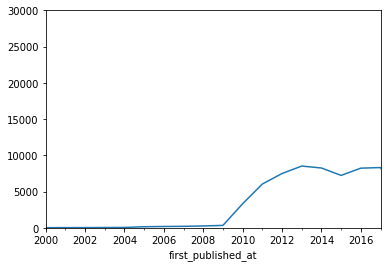

In [155]:
predictions_dedup = predictions.drop_duplicates('content_id')
predicted = predictions_dedup['first_published_at'].resample('Y').count().plot()
predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
predicted.set_ylim([0, 30000])

In [69]:
no_predictions['first_published_at_y'] = pd.to_datetime(no_predictions['first_published_at_y'])
no_predictions.index = no_predictions['first_published_at_y']

In [79]:
no_predictions['content_id'].nunique()

22379

In [157]:
no_predictions.sort_values(['prob_y', 'content_id'], ascending=False)

,content_id,taxon2_x,prob_x,taxon2label_x,base_path_x,body_x,combined_text_x,content_purpose_document_supertype_x,content_purpose_subgroup_x,content_purpose_supergroup_x,...,public_updated_at_y,publishing_app_y,search_user_need_document_supertype_y,taxon_id_y,taxons_y,title_y,untagged_type_y,updated_at_y,user_journey_document_supertype_y,_merge
first_published_at_y,,,,,,,,,,,,,,,,,,,,,
2012-03-01 00:00:00,5fa790d7-7631-11e4-a3cb-005056011aef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2012-03-01 00:00:00.000,whitehall,government,NaN,NaN,bladder cancer and pre-bake aluminium smelters...,untagged,2018-03-08 18:04:58.815,thing,right_only
2016-02-29 09:24:10,f532b322-61ad-484d-991b-604130ff6182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-04-24 13:59:37.000,whitehall,NaN,NaN,NaN,dr simon lyster,untagged,2017-04-24 13:59:37.952,thing,right_only
2013-11-21 00:00:00,5eeff75c-7631-11e4-a3cb-005056011aef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2013-11-21 00:00:00.000,whitehall,government,NaN,NaN,leadership and standards in the police: respon...,untagged,2018-01-10 12:53:52.447,thing,right_only
2013-07-15 20:35:00,5e3a4bae-7631-11e4-a3cb-005056011aef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2013-07-15 20:35:00.000,whitehall,government,NaN,NaN,president thein sein makes historic visit to t...,untagged,2018-02-23 14:26:31.618,thing,right_only
2017-09-21 15:12:42,16a8a00f-de9b-44bb-81b6-9567e717dc70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-09-21 15:12:42.000,whitehall,government,NaN,NaN,home guard service questionnaire,untagged,2018-03-08 17:17:57.147,thing,right_only
2011-01-11 00:00:00,5e10d684-7631-11e4-a3cb-005056011aef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2011-01-11 00:00:00.000,whitehall,NaN,NaN,NaN,number 10 press briefing - morning from 11 jan...,untagged,2017-10-10 11:59:18.324,thing,right_only
2012-09-18 00:00:00,5dc8b7f5-7631-11e4-a3cb-005056011aef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2012-09-18 00:00:00.000,whitehall,government,NaN,NaN,the family journey: 1 year on - research brief,untagged,2018-02-26 17:00:19.765,thing,right_only
2014-11-06 11:53:37,602c6b02-7631-11e4-a3cb-005056011aef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,whitehall,NaN,22411562-4c65-405e-b0df-28cb0326a141,NaN,new chair to advise on enhancing access to tra...,old_taxons,NaN,NaN,right_only
2016-02-29 09:24:10,85395766-c0f1-11e4-8223-005056011aef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2014-06-12 11:15:52.000,whitehall,NaN,NaN,NaN,erik wilson,untagged,2017-03-27 11:11:10.319,thing,right_only


In [159]:
no_predictions_dedup = no_predictions.drop_duplicates('content_id')

In [160]:
no_predictions_dedup.columns

Index(['content_id', 'taxon2_x', 'prob_x', 'taxon2label_x', 'base_path_x',
       'body_x', 'combined_text_x', 'content_purpose_document_supertype_x',
       'content_purpose_subgroup_x', 'content_purpose_supergroup_x',
       'description_x', 'details_x', 'document_type_x', 'document_type_gp_x',
       'email_document_supertype_x', 'first_published_at_x',
       'government_document_supertype_x', 'locale_x',
       'navigation_document_supertype_x', 'primary_publishing_organisation_x',
       'public_updated_at_x', 'publishing_app_x',
       'search_user_need_document_supertype_x', 'taxon_id_x', 'taxons_x',
       'title_x', 'untagged_type_x', 'updated_at_x',
       'user_journey_document_supertype_x', 'taxon2_y', 'prob_y',
       'taxon2label_y', 'base_path_y', 'body_y', 'combined_text_y',
       'content_purpose_document_supertype_y', 'content_purpose_subgroup_y',
       'content_purpose_supergroup_y', 'description_y', 'details_y',
       'document_type_y', 'document_type_gp_y', 'em

In [161]:
cols =np.arange(1, 29)
cols

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [167]:
hardtotag_guidance = no_predictions[no_predictions['document_type_y']=='guidance'].drop(no_predictions.columns[cols], axis=1 ).sort_values('prob_y')

In [168]:
hardtotag_guidance.groupby('taxon2label_y').size()

taxon2label_y
Administrative justice reform                                 1033
Adoption, fostering and surrogacy                             1033
Afghanistan                                                   1033
Armed Forces Covenant                                         1033
Armed forces                                                  1033
Armed forces and Ministry of Defence reform                   1033
Armed forces support for activities in the UK                 1033
Arts and culture                                              1033
Assessing environmental impact                                1033
Asylum and human rights                                       1033
Attorney General guidance to the legal profession             1033
Aviation                                                      1033
Benefits entitlement                                          1033
Benefits for families                                         1033
Biodiversity and ecosystems                     

In [164]:
hardtotag_guidance[['content_id', 'title_y', 'description_y', 'body_y', 'prob_y', 'taxon2label_y' ]].to_csv(os.path.join(DATADIR, 'hardtotag_guidance.csv.gz'), compression='gzip')

(30, 47)

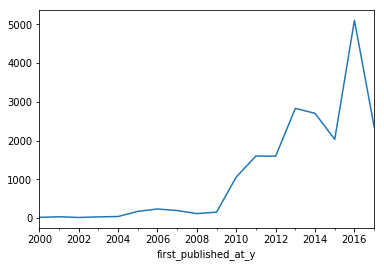

In [81]:
not_predicted = no_predictions_dedup['first_published_at_y'].resample('Y').count().plot()
not_predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))

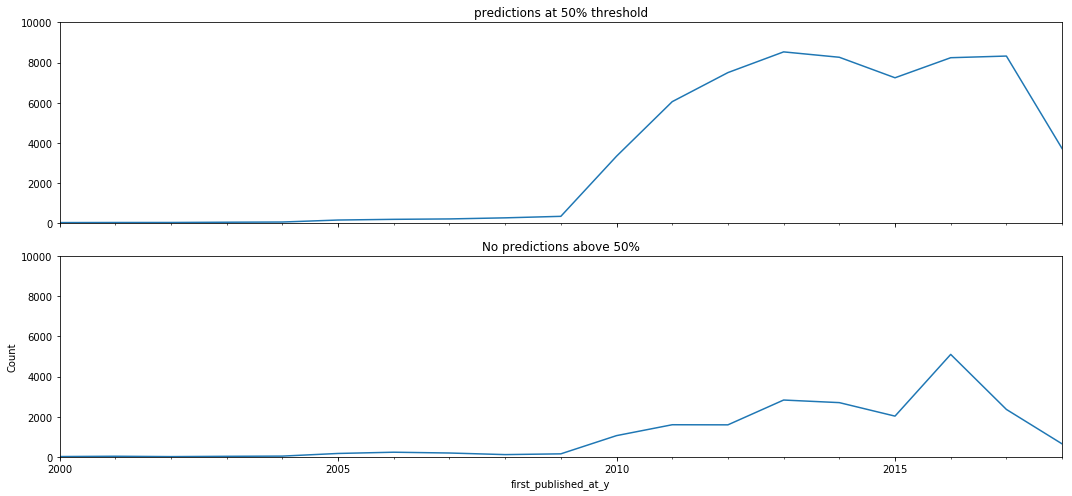

In [87]:

fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.title('predictions at 50% threshold')
predicted = predictions_dedup['first_published_at'].resample('Y').count().plot()
predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))
predicted.set_ylim([0, 10000])
predicted.axes.get_xaxis().set_ticklabels([])
predicted.set_xlabel('')

plt.subplot(2, 1, 2)
not_predicted = no_predictions_dedup['first_published_at_y'].resample('Y').count().plot()
not_predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))
plt.title('No predictions above 50%')
plt.ylabel('Count')
not_predicted.set_ylim([0, 10000])






fig.tight_layout()

In [116]:

doctype_grouped = predictions_dedup.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = doctype_grouped.unstack('document_type', fill_value=0)

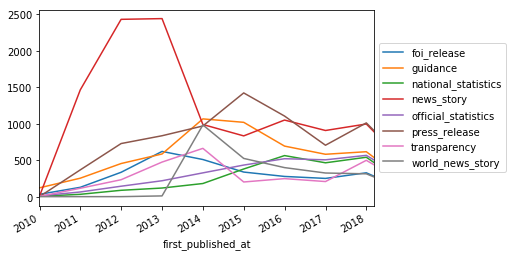

In [117]:
top_count = count_by_year.loc[:,count_by_year.max() > 500]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [118]:
lab = count_by_year.stack().reset_index()
lab.columns = ['date', 'document_type', 'percent']
bydoctype_year = lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)

top_pct = bydoctype_pcts[['organisation', 
                          'person', 
                          'placeholder_person', 
                          'regulation', 
                          'world_news_story', 
                          'news_story', 
                          'foi_release',
                          'guidance',
                          'national_statistics',
                          'official_statistics', 
                          'press_release',
                          'transparency'
 ]]

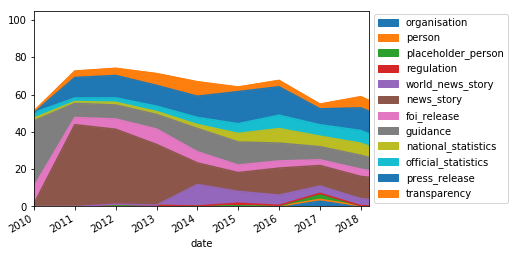

In [119]:
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))

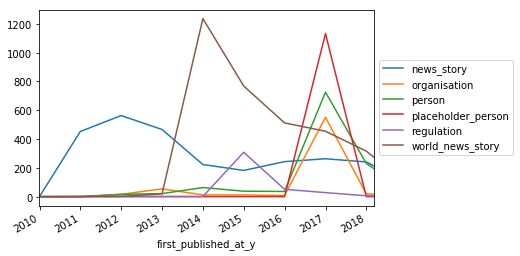

In [111]:
doctype_grouped = no_predictions_dedup.groupby(['document_type_y', pd.Grouper(freq='Y')])['first_published_at_y'].count()
count_by_year = doctype_grouped.unstack('document_type_y', fill_value=0)

top_count = count_by_year.loc[:,count_by_year.max() > 300]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [114]:
lab = count_by_year.stack().reset_index()
lab.columns = ['date', 'document_type', 'percent']
bydoctype_year = lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)

top_pct = bydoctype_pcts[['organisation', 
                          'person', 
                          'placeholder_person', 
                          'regulation', 
                          'world_news_story', 
                          'news_story', 
                          'foi_release',
                          'guidance',
                          'national_statistics',
                          'official_statistics', 
                          'press_release',
                          'transparency'
 ]]



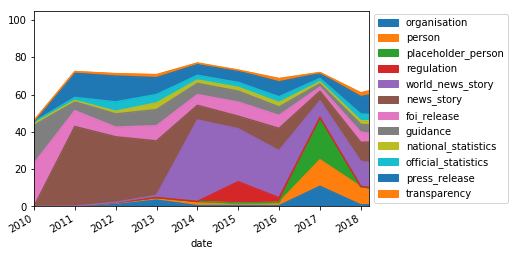

In [115]:
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))